In [ ]:
# !nvcc --version
# !cat /usr/local/cuda/version.txt

In [ ]:
# !pip show catboost

In [1]:
!pip install --upgrade catboost

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import warnings
warnings.filterwarnings("ignore")

import os, sys

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# working_directory = "/content/drive/colab"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
print(os.getcwd())

/content


In [5]:
os.chdir('/content/drive/MyDrive/colab')

In [6]:
os.listdir()

['Churn_Modelling.csv',
 'test.csv',
 'train.csv',
 'applied-bank_churn.ipynb',
 'catboost_info',
 'applied.ipynb',
 'kaggle_obesity-risk']

In [7]:
# working_directory = os.getcwd()
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_test_ov = df_test.copy()
df_orig = pd.read_csv("Churn_Modelling.csv")

In [8]:
# df_train.drop(columns={"CustomerId"}, inplace=True)
# df_test.drop(columns={"CustomerId"}, inplace=True)
# df_orig.drop(columns={"CustomerId"}, inplace=True)


# df_train.drop(columns={"Surname"}, inplace=True)
# df_test.drop(columns={"Surname"}, inplace=True)
# df_orig.drop(columns={"Surname"}, inplace=True)

# Changing the data type of id
# df_train.id = df_train.id.astype("category")
# df_test.id = df_test.id.astype("category")
df_orig.rename(columns={'RowNumber':'id'}, inplace=True)
# df_orig.id = df_test.id.astype("category")


Scaling

In [9]:
scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
###
for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c+"_scaled"] = (df_test[c] - min_value) / (max_value - min_value)

### Aggregate Features

#### Aggregate on ['CustomerId', 'Surname', 'Geography', 'Gender']

In [10]:
df_all = pd.concat([df_train,df_test]).reset_index(drop=True)
aggs = {
    'Age': ['min','max', 'mean'],
    'Balance': ['min','max', 'mean','sum'],
    'NumOfProducts': ['mean','sum'],
    'IsActiveMember': ['min','max', 'mean','sum'],
    'CreditScore': ['min','max', 'mean'],
    'EstimatedSalary': ['min','max', 'mean','sum'],
    'id': 'count',
}
df_grps=df_all.groupby(['CustomerId', 'Surname', 'Geography', 'Gender']).agg(aggs).reset_index()
df_grps.columns = list(map(''.join, df_grps.columns.values))
print(len(df_grps))
df_grps.head()

235258


,CustomerId,Surname,Geography,Gender,Agemin,Agemax,Agemean,Balancemin,Balancemax,Balancemean,...,IsActiveMembermean,IsActiveMembersum,CreditScoremin,CreditScoremax,CreditScoremean,EstimatedSalarymin,EstimatedSalarymax,EstimatedSalarymean,EstimatedSalarysum,idcount
0,15565701,Bruno,Spain,Male,49.0,49.0,49.0,0.00,0.00,0.00,...,1.0,1.0,846,846,846.0,90280.70,90280.70,90280.70,90280.70,1
1,15565701,Chineze,France,Male,32.0,32.0,32.0,107209.58,107209.58,107209.58,...,1.0,1.0,705,705,705.0,129822.79,129822.79,129822.79,129822.79,1
2,15565701,Ferri,France,Female,39.0,39.0,39.0,161993.89,161993.89,161993.89,...,0.0,0.0,698,698,698.0,90212.38,90212.38,90212.38,90212.38,1
3,15565701,Ferri,Spain,Male,34.0,34.0,34.0,161993.89,161993.89,161993.89,...,0.0,0.0,707,707,707.0,94912.78,94912.78,94912.78,94912.78,1
4,15565706,Akobundu,France,Male,37.0,40.0,38.5,0.00,0.00,0.00,...,0.5,1.0,612,682,647.0,83256.26,83256.26,83256.26,166512.52,2


#### Aggregate on ['CustomerId', 'Surname', 'Age', 'Gender']

In [11]:
aggs = {
    'Balance': ['min','max', 'mean','sum'],
    'NumOfProducts': ['mean','sum'],
    'IsActiveMember': ['min','max', 'mean','sum'],
    'CreditScore': ['min','max', 'mean'],
    'EstimatedSalary': ['min','max', 'mean','sum'],
    'id': 'count',
}
df_grps1=df_all.groupby(['CustomerId', 'Surname', 'Age', 'Gender']).agg(aggs).reset_index()
df_grps1.columns = list(map('grps1'.join, df_grps1.columns.values))
print(len(df_grps1))
df_grps1=df_grps1.rename(columns={'CustomerIdgrps1':'CustomerId','Surnamegrps1':'Surname',
                                 'Agegrps1':'Age','Gendergrps1':'Gender'})
df_grps1.head()

252537


,CustomerId,Surname,Age,Gender,Balancegrps1min,Balancegrps1max,Balancegrps1mean,Balancegrps1sum,NumOfProductsgrps1mean,NumOfProductsgrps1sum,...,IsActiveMembergrps1mean,IsActiveMembergrps1sum,CreditScoregrps1min,CreditScoregrps1max,CreditScoregrps1mean,EstimatedSalarygrps1min,EstimatedSalarygrps1max,EstimatedSalarygrps1mean,EstimatedSalarygrps1sum,idgrps1count
0,15565701,Bruno,49.0,Male,0.00,0.00,0.00,0.00,2.0,2,...,1.0,1.0,846,846,846.0,90280.70,90280.70,90280.70,90280.70,1
1,15565701,Chineze,32.0,Male,107209.58,107209.58,107209.58,107209.58,1.0,1,...,1.0,1.0,705,705,705.0,129822.79,129822.79,129822.79,129822.79,1
2,15565701,Ferri,34.0,Male,161993.89,161993.89,161993.89,161993.89,1.0,1,...,0.0,0.0,707,707,707.0,94912.78,94912.78,94912.78,94912.78,1
3,15565701,Ferri,39.0,Female,161993.89,161993.89,161993.89,161993.89,1.0,1,...,0.0,0.0,698,698,698.0,90212.38,90212.38,90212.38,90212.38,1
4,15565706,Akobundu,35.0,Male,0.00,0.00,0.00,0.00,1.5,3,...,0.5,1.0,663,787,725.0,83256.26,83256.26,83256.26,166512.52,2


Exited Lag and Lead Features
<br> Inspiration from https://www.kaggle.com/competitions/playground-series-s4e1/discussion/472497

In [12]:
exitGrpBy=['CustomerId', 'Surname',  'Gender','Geography','EstimatedSalary']

exitSrtBy=['CustomerId', 'Surname',  'Gender','Geography',
       'Age', 'Tenure']
##
df_all_Exits=df_all.copy()
df_all_Exits['Exited']=df_all_Exits['Exited'].fillna(-1)
df_all_Exits=df_all_Exits.sort_values(exitSrtBy)
df_all_Exits['Exit_lag1']=df_all_Exits.groupby(exitGrpBy)['Exited'].shift(1)
df_all_Exits['Exit_lag2']=df_all_Exits.groupby(exitGrpBy)['Exited'].shift(2)
df_all_Exits['Exit_lag3']=df_all_Exits.groupby(exitGrpBy)['Exited'].shift(3)

df_all_Exits['Exit_lead1']=df_all_Exits.groupby(exitGrpBy)['Exited'].shift(-1)
df_all_Exits['Exit_lead2']=df_all_Exits.groupby(exitGrpBy)['Exited'].shift(-2)
df_all_Exits['Exit_lead3']=df_all_Exits.groupby(exitGrpBy)['Exited'].shift(-3)

df_all_Exits['Balance_lag_diff1']=df_all_Exits['Balance'].shift(1)
df_all_Exits['Balance_lead_diff1']=df_all_Exits['Balance'].shift(-1)

df_all_Exits=df_all_Exits[['id','Exit_lag1','Exit_lag2','Exit_lag3',
                         'Exit_lead1','Exit_lead2','Exit_lead3',
                          'Balance_lag_diff1','Balance_lead_diff1']]
df_all_Exits=df_all_Exits.fillna(-1).astype('int')
df_all_Exits.head()

,id,Exit_lag1,Exit_lag2,Exit_lag3,Exit_lead1,Exit_lead2,Exit_lead3,Balance_lag_diff1,Balance_lead_diff1
87277,87277,-1,-1,-1,-1,-1,-1,-1,107209
140882,140882,-1,-1,-1,-1,-1,-1,0,161993
160702,160702,-1,-1,-1,-1,-1,-1,107209,161993
259273,259273,-1,-1,-1,-1,-1,-1,161993,0
106193,106193,-1,-1,-1,-1,-1,-1,161993,0


Features from Original File
<br> Idea from https://www.kaggle.com/competitions/playground-series-s4e1/discussion/472496

In [13]:
def getGrpsIndv(df_orig,df_train,df_test,grpCols,nm):
    grpBy=[]
    for c in grpCols:
        for i in grpCols:
            if c!=i:
                grpBy=[c,i]
                grpBy=[c,i]
                df_tmp=df_orig.groupby(grpBy).agg({'id':'count','Exited':{'mean'}}).reset_index()
                df_tmp.columns=list(map(''.join, (list(df_tmp.columns.values))))
                sepCols=df_tmp.columns.drop(grpBy)+nm+'_ind_'+c+'-'+i
                df_tmp.columns=list(grpBy)+list(sepCols)
                #
                df_train=df_train.merge(df_tmp,how='left')
                df_test=df_test.merge(df_tmp,how='left')

                df_train[sepCols]=df_train[sepCols].fillna(0)
                df_test[sepCols]=df_test[sepCols].fillna(0)

                df_train[sepCols]=df_train[sepCols].astype('int')
                df_test[sepCols]=df_test[sepCols].astype('int')
    return df_train,df_test

In [14]:
def getGrps(df_orig,df_train,df_test,grpCols,nm):
    grpBy=[]
    for c in grpCols:
        grpBy.append(c)
        df_tmp=df_orig.groupby(grpBy).agg({'id':'count','Exited':{'sum'}}).reset_index()
        df_tmp.columns=list(map(''.join, (list(df_tmp.columns.values))))
        sepCols=df_tmp.columns.drop(grpBy)+nm+'_grps_'+c
        df_tmp.columns=list(grpBy)+list(sepCols)
                #
        df_train=df_train.merge(df_tmp,how='left')
        df_test=df_test.merge(df_tmp,how='left')

        df_train[sepCols]=df_train[sepCols].fillna(0)
        df_test[sepCols]=df_test[sepCols].fillna(0)

        df_train[sepCols]=df_train[sepCols].astype('int')
        df_test[sepCols]=df_test[sepCols].astype('int')
    return df_train,df_test

In [15]:
grpCols=['CustomerId', 'Surname', 'Geography', 'Gender', 'Age', 'Tenure', 'CreditScore',
         'NumOfProducts','HasCrCard',
         'IsActiveMember' ,'EstimatedSalary','Balance']
df_train,df_test=getGrps(df_orig,df_train,df_test,grpCols,'Orig_groups')
df_train,df_test=getGrpsIndv(df_orig,df_train,df_test,grpCols,'Orig_ind')

In [16]:
print(df_train.shape)
df_train.head()

(165034, 306)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,ididOrig_ind_ind_Balance-CreditScore,ExitedmeanOrig_ind_ind_Balance-CreditScore,ididOrig_ind_ind_Balance-NumOfProducts,ExitedmeanOrig_ind_ind_Balance-NumOfProducts,ididOrig_ind_ind_Balance-HasCrCard,ExitedmeanOrig_ind_ind_Balance-HasCrCard,ididOrig_ind_ind_Balance-IsActiveMember,ExitedmeanOrig_ind_ind_Balance-IsActiveMember,ididOrig_ind_ind_Balance-EstimatedSalary,ExitedmeanOrig_ind_ind_Balance-EstimatedSalary
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,10,0,2600,0,2592,0,1744,0,0,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,15,0,2600,0,2592,0,1873,0,0,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,26,0,2600,0,2592,0,1744,0,0,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,0,0,0,0,0,0,0,0,0,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,11,0,2600,0,2592,0,1873,0,0,0


Feature Engineering

In [17]:
def getFeats(df):

    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    df['Sur_Geo_Gend_Sal'] = df['Surname']+df['Geography']+df['Gender']+np.round(df.EstimatedSalary).astype('str')

    df = df.merge(df_grps,how='left',on=['CustomerId', 'Surname', 'Geography', 'Gender'])
    df = df.merge(df_grps1,how='left',on=['CustomerId', 'Surname', 'Age', 'Gender'])
    df = df.merge(df_all_Exits,how='left')
    return df

In [18]:
df_train = getFeats(df_train)
df_test = getFeats(df_test)
##
feat_cols=df_train.columns.drop(['id','Exited'])
feat_cols=feat_cols.drop(scale_cols)
print("Number of Features:",len(feat_cols))
print(feat_cols)
df_train.head()

Number of Features: 352
Index(['CustomerId', 'Surname', 'Geography', 'Gender', 'Tenure',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Age_scaled',
       'CreditScore_scaled',
       ...
       'EstimatedSalarygrps1sum', 'idgrps1count', 'Exit_lag1', 'Exit_lag2',
       'Exit_lag3', 'Exit_lead1', 'Exit_lead2', 'Exit_lead3',
       'Balance_lag_diff1', 'Balance_lead_diff1'],
      dtype='object', length=352)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,EstimatedSalarygrps1sum,idgrps1count,Exit_lag1,Exit_lag2,Exit_lag3,Exit_lead1,Exit_lead2,Exit_lead3,Balance_lag_diff1,Balance_lead_diff1
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,181449.97,1,-1,-1,-1,-1,-1,-1,0,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,49503.50,1,-1,-1,-1,-1,-1,-1,115587,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,184866.69,1,-1,-1,-1,-1,-1,-1,0,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,84560.88,1,-1,-1,-1,-1,-1,-1,0,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,15068.83,1,-1,-1,-1,-1,-1,-1,135759,142084


In [19]:
X=df_train[feat_cols]
y=df_train['Exited']
##
cat_features = np.where(X.dtypes != np.float64)[0]

In [20]:
RAND_VAL=77
num_folds=5 ## Number of folds
n_est=6000 ## Number of estimators

In [21]:
df_test[feat_cols]

,CustomerId,Surname,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Age_scaled,CreditScore_scaled,...,EstimatedSalarygrps1sum,idgrps1count,Exit_lag1,Exit_lag2,Exit_lag3,Exit_lead1,Exit_lead2,Exit_lead3,Balance_lag_diff1,Balance_lead_diff1
0,15773898,Lucchese,France,Female,2,2,0.0,1.0,0.067568,0.472,...,160976.75,1,-1,-1,-1,-1,-1,-1,0,0
1,15782418,Nott,France,Female,2,1,1.0,0.0,0.378378,0.666,...,72549.27,1,-1,-1,-1,-1,-1,-1,0,113909
2,15807120,K?,France,Female,7,2,1.0,0.0,0.216216,0.612,...,138882.09,1,-1,-1,-1,-1,-1,-1,108891,0
3,15808905,O'Donnell,France,Male,8,1,1.0,0.0,0.243243,0.662,...,113931.57,1,-1,-1,-1,-1,-1,-1,0,0
4,15607314,Higgins,Germany,Male,10,1,1.0,0.0,0.270270,0.804,...,139431.00,1,-1,-1,-1,-1,-1,-1,143212,139183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,15662091,P'eng,Spain,Male,7,1,1.0,1.0,0.148649,0.440,...,148087.62,1,-1,-1,-1,-1,-1,-1,0,0
110019,15774133,Cox,France,Female,4,1,1.0,1.0,0.243243,0.450,...,42181.68,1,1,0,-1,-1,-1,-1,0,110791
110020,15728456,Ch'iu,France,Male,2,2,1.0,0.0,0.175676,0.724,...,16287.38,1,-1,-1,-1,-1,-1,-1,54817,118546
110021,15687541,Yegorova,France,Female,3,1,1.0,1.0,0.189189,0.718,...,158816.58,1,-1,-1,-1,-1,-1,-1,0,0


In [22]:
folds = StratifiedKFold(n_splits=num_folds,random_state=RAND_VAL,shuffle=True)
test_preds = np.empty((num_folds, len(df_test)))
auc_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]

    train_pool = Pool(X_train, y_train,cat_features=cat_features)
    val_pool = Pool(X_val, y_val,cat_features=cat_features)

    clf = CatBoostClassifier(
    eval_metric='AUC',
    task_type='GPU',
    learning_rate=0.02,
    iterations=n_est)
    clf.fit(train_pool, eval_set=val_pool,verbose=300)

    y_pred_val = clf.predict_proba(X_val[feat_cols])[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals.append(auc_val)

    y_pred_test = clf.predict_proba(df_test[feat_cols])[:,1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8587358	best: 0.8587358 (0)	total: 225ms	remaining: 22m 31s
300:	test: 0.9003995	best: 0.9003995 (300)	total: 56.6s	remaining: 17m 51s
600:	test: 0.9026612	best: 0.9026612 (600)	total: 1m 56s	remaining: 17m 23s
900:	test: 0.9036410	best: 0.9036410 (900)	total: 2m 53s	remaining: 16m 19s
1200:	test: 0.9041693	best: 0.9041693 (1200)	total: 3m 49s	remaining: 15m 17s
1500:	test: 0.9045051	best: 0.9045051 (1500)	total: 4m 46s	remaining: 14m 17s
1800:	test: 0.9047521	best: 0.9047521 (1800)	total: 5m 43s	remaining: 13m 20s
2100:	test: 0.9049475	best: 0.9049475 (2100)	total: 6m 41s	remaining: 12m 24s
2400:	test: 0.9051583	best: 0.9051635 (2375)	total: 7m 39s	remaining: 11m 28s
2700:	test: 0.9052491	best: 0.9052522 (2695)	total: 8m 36s	remaining: 10m 30s
3000:	test: 0.9053755	best: 0.9053774 (2995)	total: 9m 33s	remaining: 9m 32s
3300:	test: 0.9054525	best: 0.9054551 (3295)	total: 10m 30s	remaining: 8m 35s
3600:	test: 0.9055136	best: 0.9055154 (3595)	total: 11m 28s	remaining: 7m 38s
3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8645876	best: 0.8645876 (0)	total: 217ms	remaining: 21m 43s
300:	test: 0.8997916	best: 0.8997916 (300)	total: 57.9s	remaining: 18m 15s
600:	test: 0.9016652	best: 0.9016652 (600)	total: 1m 57s	remaining: 17m 38s
900:	test: 0.9023697	best: 0.9023697 (900)	total: 2m 55s	remaining: 16m 35s
1200:	test: 0.9028667	best: 0.9028667 (1200)	total: 3m 52s	remaining: 15m 30s
1500:	test: 0.9032075	best: 0.9032075 (1500)	total: 4m 51s	remaining: 14m 32s
1800:	test: 0.9034418	best: 0.9034418 (1800)	total: 5m 48s	remaining: 13m 32s
2100:	test: 0.9036143	best: 0.9036143 (2100)	total: 6m 46s	remaining: 12m 35s
2400:	test: 0.9038386	best: 0.9038394 (2395)	total: 7m 45s	remaining: 11m 37s
2700:	test: 0.9039621	best: 0.9039714 (2680)	total: 8m 43s	remaining: 10m 39s
3000:	test: 0.9040681	best: 0.9040723 (2980)	total: 9m 43s	remaining: 9m 43s
3300:	test: 0.9041484	best: 0.9041484 (3300)	total: 10m 41s	remaining: 8m 44s
3600:	test: 0.9042315	best: 0.9042394 (3580)	total: 11m 39s	remaining: 7m 45s
3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8697219	best: 0.8697219 (0)	total: 212ms	remaining: 21m 9s
300:	test: 0.9054292	best: 0.9054292 (300)	total: 58.8s	remaining: 18m 32s
600:	test: 0.9073217	best: 0.9073217 (600)	total: 1m 57s	remaining: 17m 32s
900:	test: 0.9080229	best: 0.9080229 (900)	total: 2m 54s	remaining: 16m 27s
1200:	test: 0.9084194	best: 0.9084194 (1200)	total: 3m 52s	remaining: 15m 29s
1500:	test: 0.9087017	best: 0.9087017 (1500)	total: 4m 53s	remaining: 14m 39s
1800:	test: 0.9089292	best: 0.9089292 (1800)	total: 5m 53s	remaining: 13m 44s
2100:	test: 0.9090546	best: 0.9090546 (2100)	total: 6m 51s	remaining: 12m 44s
2400:	test: 0.9091040	best: 0.9091083 (2395)	total: 7m 51s	remaining: 11m 47s
2700:	test: 0.9091555	best: 0.9091636 (2625)	total: 8m 51s	remaining: 10m 48s
3000:	test: 0.9092500	best: 0.9092500 (3000)	total: 9m 51s	remaining: 9m 51s
3300:	test: 0.9093237	best: 0.9093239 (3280)	total: 10m 51s	remaining: 8m 52s
3600:	test: 0.9093601	best: 0.9093643 (3595)	total: 11m 50s	remaining: 7m 53s
39

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8694175	best: 0.8694175 (0)	total: 217ms	remaining: 21m 44s
300:	test: 0.9009249	best: 0.9009249 (300)	total: 1m 1s	remaining: 19m 25s
600:	test: 0.9028609	best: 0.9028609 (600)	total: 2m 3s	remaining: 18m 26s
900:	test: 0.9037158	best: 0.9037158 (900)	total: 3m 2s	remaining: 17m 10s
1200:	test: 0.9041072	best: 0.9041072 (1200)	total: 4m 2s	remaining: 16m 9s
1500:	test: 0.9043772	best: 0.9043772 (1500)	total: 5m 2s	remaining: 15m 7s
1800:	test: 0.9046770	best: 0.9046770 (1800)	total: 6m 1s	remaining: 14m 3s
2100:	test: 0.9049666	best: 0.9049666 (2100)	total: 7m 1s	remaining: 13m 3s
2400:	test: 0.9051185	best: 0.9051185 (2400)	total: 8m 2s	remaining: 12m 3s
2700:	test: 0.9052038	best: 0.9052045 (2690)	total: 9m 2s	remaining: 11m 2s
3000:	test: 0.9052614	best: 0.9052614 (3000)	total: 10m 3s	remaining: 10m 3s
3300:	test: 0.9053580	best: 0.9053580 (3300)	total: 11m 4s	remaining: 9m 3s
3600:	test: 0.9054444	best: 0.9054487 (3595)	total: 12m 6s	remaining: 8m 4s
3900:	test: 0.90556

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8661191	best: 0.8661191 (0)	total: 212ms	remaining: 21m 12s
300:	test: 0.9016378	best: 0.9016378 (300)	total: 1m	remaining: 19m 7s
600:	test: 0.9035981	best: 0.9035981 (600)	total: 2m 1s	remaining: 18m 13s
900:	test: 0.9044172	best: 0.9044172 (900)	total: 3m	remaining: 17m
1200:	test: 0.9048024	best: 0.9048048 (1195)	total: 3m 58s	remaining: 15m 54s
1500:	test: 0.9051313	best: 0.9051313 (1500)	total: 4m 57s	remaining: 14m 51s
1800:	test: 0.9054101	best: 0.9054145 (1795)	total: 5m 57s	remaining: 13m 52s
2100:	test: 0.9055559	best: 0.9055559 (2100)	total: 6m 57s	remaining: 12m 53s
2400:	test: 0.9057388	best: 0.9057392 (2385)	total: 7m 56s	remaining: 11m 54s
2700:	test: 0.9058353	best: 0.9058394 (2685)	total: 8m 56s	remaining: 10m 55s
3000:	test: 0.9059376	best: 0.9059436 (2985)	total: 9m 57s	remaining: 9m 57s
3300:	test: 0.9060000	best: 0.9060000 (3300)	total: 10m 55s	remaining: 8m 56s
3600:	test: 0.9060887	best: 0.9060887 (3600)	total: 11m 54s	remaining: 7m 55s
3900:	test: 0.

In [23]:
print(np.mean(auc_vals))

0.9064774451540856


In [24]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 8.7 MB/s eta 0:00:00


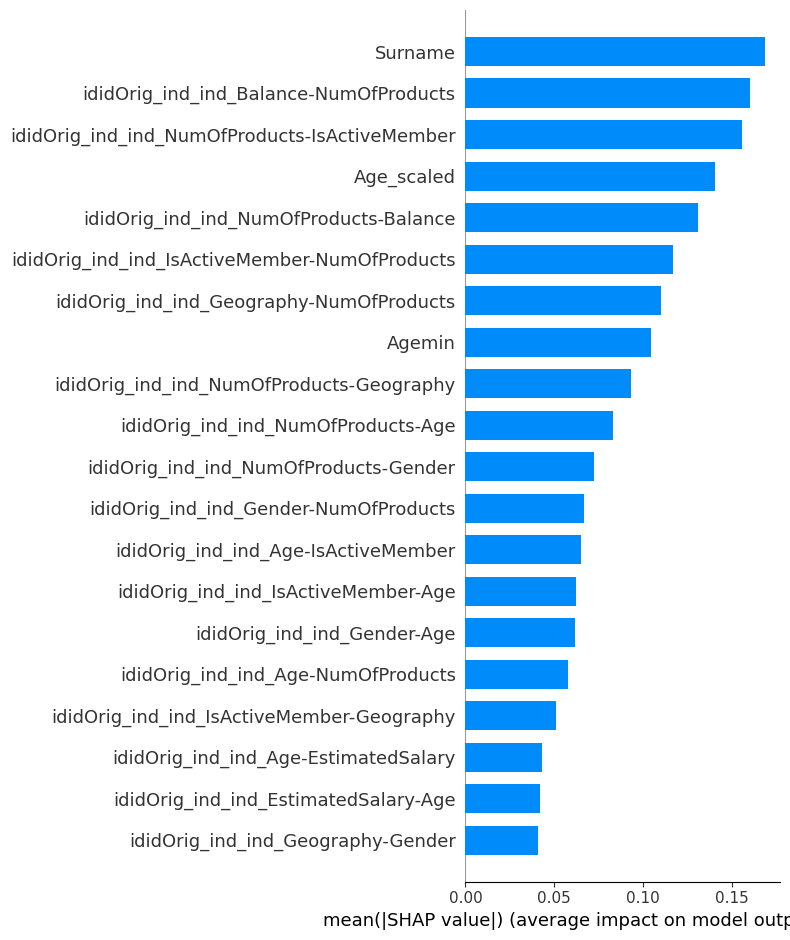

In [25]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_pool)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [26]:
join_cols=list(df_orig.columns.drop(['Exited']))
df_orig.rename(columns={'Exited':'Exited_Orig'},inplace=True)
df_orig['Exited_Orig']=df_orig['Exited_Orig'].map({0:1,1:0})
df_test_ov=df_test_ov.merge(df_orig,on=join_cols,how='left')[['id','Exited_Orig']].fillna(-1)
df_test_ov.head()

,id,Exited_Orig
0,165034,-1.0
1,165035,-1.0
2,165036,-1.0
3,165037,-1.0
4,165038,-1.0


In [27]:
y_pred = test_preds.mean(axis=0)
df_sub = df_test_ov[['id','Exited_Orig']]
df_sub['Exited'] = np.where(df_sub.Exited_Orig==-1,y_pred,df_sub.Exited_Orig)
df_sub.drop('Exited_Orig',axis=1,inplace=True)
df_sub.head()

df_sub.to_csv("applied.csv",index=False)

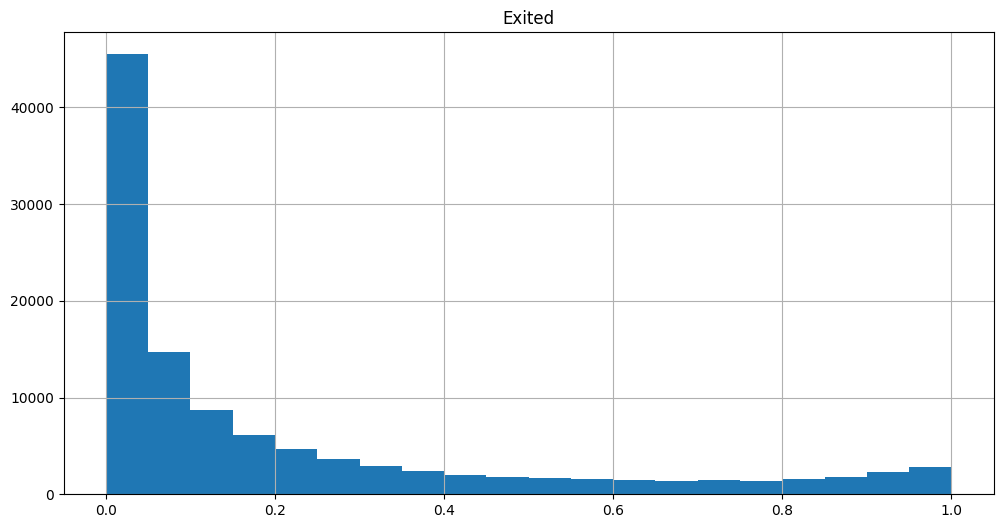

In [28]:
df_sub.hist(column='Exited', bins=20, range=[0,1],figsize=(12,6))
plt.show()